In [453]:
import pandas as pd
import numpy as np
from torch import nn
from sklearn.preprocessing import PowerTransformer, StandardScaler
from torchviz import make_dot
from itertools import islice
import torch
import numpy
from sklearn.model_selection import train_test_split
import statistics as stats
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import hiddenlayer as hl
import graphviz
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

# Importing the data

In [454]:
def to_list(str):
    '''
    :param str: string representing a list of centipawn losses
    :return: list of integer centipawn losses
    '''
    string = str.replace('[','').replace(']','')
    ls = string.split(',')
    list = [float(i) for i in ls]

    return list

In [455]:
def black_process(evals, clocks):
    '''
    :param eval: list of integer centipawn losses
    :return: array of lists of [evaluation, centipawn loss]
    '''

    i = 0
    old_eval = 36
    res = []

    # iterating through centipawn losses
    for eval in evals:

        # subtracting the cpl for white's moves
        if i % 2 ==1:
            cpl = eval - old_eval
            res.append([old_eval,cpl,clocks[i]])
            old_eval = eval
            i += 1

        # adding the cpl for black's moves
        else:
            old_eval = eval
            i+=1

    return numpy.array(res)

In [456]:
def white_process(evals, clocks):
    '''
    :param eval: list of integer centipawn losses
    :return: array of lists of [evaluation, centipawn loss]
    '''

    i = 0
    old_eval = 36
    res = []

    # iterating through centipawn losses
    for eval in evals:

        # subtracting the cpl for white's moves
        if i % 2 ==0:
            cpl = old_eval - eval
            res.append([old_eval,cpl, clocks[i]])
            old_eval = eval
            i += 1

        # adding the cpl for black's moves
        else:
            old_eval = eval
            i+=1

    return numpy.array(res)

In [457]:
def black_process(evals, clocks):
    '''
    :param eval: list of integer centipawn losses
    :return: array of lists of [evaluation, centipawn loss]
    '''

    i = 0
    old_eval = 36
    res = []

    # iterating through centipawn losses
    for eval in evals:

        # subtracting the cpl for white's moves
        if i % 2 ==1:
            cpl = eval - old_eval
            res.append([cpl,clocks[i]])
            old_eval = eval
            i += 1

        # adding the cpl for black's moves
        else:
            old_eval = eval
            i+=1

    return numpy.array(res)

In [458]:
def white_process(evals, clocks):
    '''
    :param eval: list of integer centipawn losses
    :return: array of lists of [evaluation, centipawn loss]
    '''

    i = 0
    old_eval = 36
    res = []

    # iterating through centipawn losses
    for eval in evals:

        # subtracting the cpl for white's moves
        if i % 2 ==0:
            cpl = old_eval - eval
            res.append([cpl, clocks[i]])
            old_eval = eval
            i += 1

        # adding the cpl for black's moves
        else:
            old_eval = eval
            i+=1

    return numpy.array(res)

In [459]:
def black_clock(clocks):
    clocktimes = to_list(clocks)
    return clocks[1::2]

def white_clock(clocks):
    clocktimes = to_list(clocks)
    return clocks[::2]

In [460]:
# # reading *some* of the data
# dfs = []
#
# players = ['andreikin, dmitry', 'anand, viswanathan', 'wang, hao', 'grischuk, alexander', 'karjakin, sergey','duda, jan-krzysztof', 'radjabov, teimour', 'dominguez perez, leinier','nakamura, hikaru', 'vachier-lagrave, maxime','aronian, levon','mamedyarov, shakhriyar', 'so, wesley','ding, liren','carlsen, magnus', 'rapport, richard', 'nepomniachtchi, ian', 'giri, anish', 'firouzja, alireza', 'caruana, fabiano','zelcic, robert','khotenashvili, bela', 'bischoff, klaus', 'hoffmann, asa','kaufman, lawrence','bellaiche, elise','vidyarthi, omya', 'eade, don','bueckert, diana','mirza, diana','ryan, john','sloan, sam','szabo, marcell','kiseleva, arina','bhagyashree g patil','kriti mayur patel','wiebke, elfriede','peschk, kathrin','zozulia, anna','marin, irina-luiza','narva, regina','mozelius, peter','eriksson, bo e','hansen, mads','meskenas, vaidas','eidelson, rakhil','kazarian, anna-maja','killer, oliver','israel, delphine','lubbe, melanie','frijling, jeroen','winkels, marcel','smirnova, ekaterina','srebrnic, ana','lucas, marco']
#
# # reading the csvs
# for player in players:
#     df = pd.read_csv('blitz/'+player +'.csv')
#     dfs.append(df)
# df = pd.concat(dfs)

In [461]:
df1 = pd.read_csv('lichess/lichess_db_standard_rated_2022-12_1499999.csv')
df2 = pd.read_csv('lichess/lichess_db_standard_rated_2022-12_1500000_2500000.csv')
df3 = pd.read_csv('lichess/lichess_db_standard_rated_2022-12_2500000_3500000.csv')
df = pd.concat([df1,df2,df3])
df = df[~df['Eval'].str.contains('None')]

In [462]:
df.value_counts('TimeControl')

TimeControl
600+0     20179
180+0     19016
180+2     16384
60+0      15746
300+0     13924
          ...  
3600+4        1
3600+8        1
420+11        1
420+14        1
960+6         1
Length: 373, dtype: int64

In [463]:
df = df[df["TimeControl"] == "180+0"]

In [464]:
print(f"Total  games: {len(df)}")

# Filtering out * values
df = df[df['WhiteELO'] != '*']
df = df[df['BlackELO'] != '*']
df[['WhiteELO', 'BlackELO']] = df[['WhiteELO', 'BlackELO']] .astype(int)

df = df[df['Eval'] != '']
df = df[df['Eval'] != '[]']

df = df[ df['Eval'].apply(lambda x: isinstance(x, str))]


# converting the evaluation to a list
df['Eval'] = df['Eval'].apply( to_list)
df['Clock'] = df['Clock'].apply(to_list)

df['WhiteEval'] =df.apply(lambda x : white_process(x.Eval, x.Clock), axis =1 )
df['BlackEval'] = df.apply(lambda x : black_process(x.Eval, x.Clock), axis =1 )



df['WhiteClock'] = df['Clock'].apply(lambda x : x[::2])
df['BlackClock'] = df['Clock'].apply(lambda x : x[1::2])

print(f"Evaluted games: {len(df['Eval'])}")

Total  games: 19016
Evaluted games: 19016


In [465]:
df_flipped = df.copy()
df_flipped['WhiteEval'] = df_flipped['BlackEval']
df_flipped['WhiteELO'] = df_flipped['BlackELO']
df_flipped['WhiteClock'] = df_flipped['BlackClock']
df_flipped['White'] = df_flipped['Black']

In [466]:
df = pd.concat([df, df_flipped])

In [467]:
players = np.array(df['White'])

In [468]:
print(f"Evaluted games: {len(df['Eval'])}")

Evaluted games: 38032


In [469]:
#df = df[df['WhiteELO'] != 2185]

In [470]:
#df = df[df['WhiteELO'] > 2450]

In [471]:
white_x = numpy.array(df['WhiteEval'])
white_length = numpy.array(df['WhiteEval'].apply(len))

black_x = numpy.array(df['WhiteEval'])
black_length = numpy.array(df['WhiteEval'].apply(len))

In [472]:
# creating and fitting a power transformer for black and white
#wpt = PowerTransformer()
wpt = StandardScaler()
white_y = numpy.concatenate(white_x)
wpt.fit(white_y)
white_transformed = wpt.transform(white_y)

bpt = PowerTransformer()
black_y = numpy.concatenate(black_x)
bpt.fit(black_y)
black_transformed = bpt.transform(black_y)

In [473]:
print(white_y)

[[ 36. 180.]
 [ -1. 178.]
 [  9. 177.]
 ...
 [ 51.  24.]
 [-10.  23.]
 [737.  20.]]


In [474]:
import itertools

In [475]:
clocks = numpy.array(df['WhiteClock'])
clock_length = numpy.array(df['WhiteClock'].apply(len))
clocks = np.array(list(itertools.chain.from_iterable(clocks)))

In [476]:
clocks

array([180., 178., 177., ...,  24.,  23.,  20.])

In [477]:
clocks = clocks.reshape(-1,1)

In [478]:
wct = StandardScaler()

In [479]:
wct.fit(clocks)

StandardScaler()

In [480]:
clocks_transformed = wct.transform(clocks)

In [481]:
def avg_cpl(white_processed):
    '''
    get the average centipawn loss from an evaluated game
    :param white_processed: list of lists of the form [evaluation, centipawn loss]
    :return: average centipawn loss (float)
    '''
    cpls = []
    for i in white_processed:
        cpls.append(i[1])
    if len(cpls) == 0:
        return float('NaN')
    else:
        return stats.mean(cpls)

In [482]:
df['White_avg_cpl'] = df['WhiteEval'].copy().apply( avg_cpl )

In [483]:
df = df[df['Eval']!='']

<AxesSubplot:>

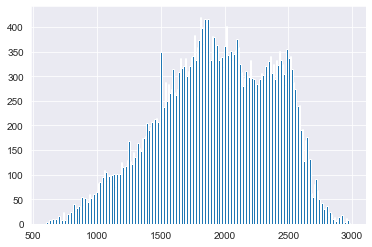

In [484]:
df['WhiteELO'].hist(bins = 200)

<AxesSubplot:xlabel='WhiteELO', ylabel='[White_avg_cpl]'>

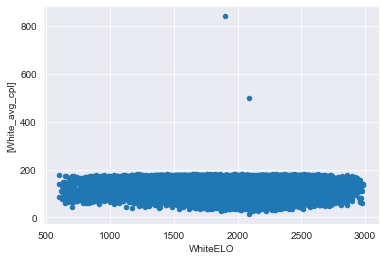

In [485]:
df.plot.scatter(x='WhiteELO', y = ['White_avg_cpl'])

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='WhiteELO', ylabel='White_avg_cpl'>

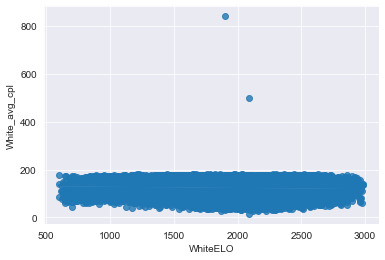

In [486]:
plt.figure()
sns.regplot(df['WhiteELO'], df['White_avg_cpl'])

In [487]:
# make a simple linear regression model.
X = np.array(df['White_avg_cpl'])
X = np.reshape(X, (len(X), 1))
y = np.array(df['WhiteELO'])
y = np.reshape(y, (len(y), 1))
regression = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

regression.fit(X_train,y_train)
regression.score(X_test,y_test)
#plt.scatter(y, pred_y)

y_pred = regression.predict(X_test)

In [488]:
# need a function now to (effieciently) change these to lists of length list
white_transformed_array = [numpy.array(list(islice(iter(white_transformed), elem)))
        for elem in white_length]

black_transformed_array = [numpy.array(list(islice(iter(black_transformed), elem)))
        for elem in black_length]

clocks_transformed_array = [numpy.array(list(islice(iter(clocks_transformed), elem)))
        for elem in clock_length]

In [489]:
print(f"Unique evaluated games: {df['Game'].nunique()}")

Unique evaluated games: 19016


# Preparing the data for the Neural Net

In [490]:
# converting evaluations and length to tensors
white_evals = [torch.tensor(i, dtype = torch.float32) for i in white_transformed_array]
white_lengths = [len(tensor) for tensor in white_evals]

black_evals = [torch.tensor(i, dtype = torch.float32) for i in black_transformed_array]
black_lengths = [len(tensor) for tensor in black_evals]

clock_tens = [torch.tensor(i, dtype = torch.float32) for i in clocks_transformed_array]
clock_lengths = [len(tensor) for tensor in clock_tens]

In [491]:
# Padding my sequences - not sure why batch first works, but it does
#inputs = torch.nn.utils.rnn.pad_sequence(evals, batch_first=True, padding_value=0.0)

In [492]:
#inputs_array = numpy.array(inputs.tolist())

In [493]:
#print(inputs.shape)

In [494]:
#inputs_list =inputs.tolist()

# normalizing... a bit hacky
#inputs_array = (numpy.array(inputs_list) - numpy.array(inputs_list).mean())/ numpy.linalg.norm(numpy.array(inputs_list))

In [495]:
#print(df['WhiteELO'].value_counts())

In [496]:
white_elo_arr = numpy.array(df['WhiteELO'])

In [497]:
#welopt = PowerTransformer(method = 'box-cox')
welopt = StandardScaler()
white_elo_arr = np.reshape(white_elo_arr, (len(white_elo_arr),1))
welopt.fit(white_elo_arr)
white_elo_transformed = welopt.transform(white_elo_arr)

(array([  73.,  200.,  453.,  794.,  971., 1297., 1793., 2385., 2903.,
        3345., 3846., 3540., 3306., 2944., 3129., 3239., 2448., 1017.,
         265.,   84.]),
 array([-2.96057703, -2.69513785, -2.42969867, -2.16425948, -1.8988203 ,
        -1.63338112, -1.36794194, -1.10250275, -0.83706357, -0.57162439,
        -0.30618521, -0.04074603,  0.22469316,  0.49013234,  0.75557152,
         1.0210107 ,  1.28644989,  1.55188907,  1.81732825,  2.08276743,
         2.34820661]),
 <BarContainer object of 20 artists>)

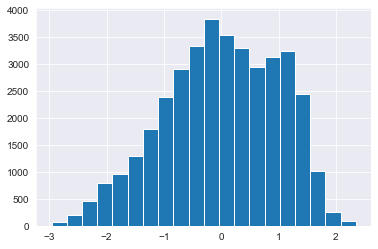

In [498]:
plt.hist(white_elo_transformed, bins =20)

In [499]:
# Converting White and Black's ELOs to tensors
white_elo = [torch.tensor(i, dtype = torch.float32) for i in white_elo_transformed]



black_elo = numpy.array(df['BlackELO'])
black_elo = [torch.tensor(i, dtype = torch.float32) for i in black_elo]

average_cpl = np.array(df['White_avg_cpl'])

# splitting into train and test
white_eval_train, white_eval_test, black_eval_train, black_eval_test, black_train, black_test, white_train, white_test, average_cpl_train, average_cpl_test, clocks_train, clocks_test  = train_test_split(white_evals, black_evals, black_elo, white_elo, average_cpl, clock_tens, test_size=0.2,random_state=0, shuffle = True)

## Baseline model

In [500]:
white_eval_train

[tensor([[-0.1828,  1.1228],
         [-0.3507,  1.0857],
         [-0.3053,  1.0672],
         [-0.2827,  1.0486],
         [-0.2736,  0.9745],
         [-0.2917,  0.9745],
         [-0.3916,  0.9559],
         [-0.2872,  0.9188],
         [-0.2690,  0.9003],
         [-0.3190,  0.8818],
         [-0.3280,  0.8818],
         [-0.3144,  0.8818],
         [-0.2827,  0.8632],
         [-0.3280,  0.7891],
         [-0.3144,  0.7520],
         [-0.2963,  0.6778],
         [-0.3280,  0.6593],
         [-0.3326,  0.5480],
         [-0.3190,  0.5295],
         [-0.2645,  0.4739],
         [-0.3462,  0.4182],
         [-0.3643,  0.2328],
         [-0.3099,  0.1958],
         [-0.3462,  0.0104],
         [ 0.3436, -0.1009],
         [-0.3008, -0.1194]]),
 tensor([[-0.1828,  1.1228],
         [-0.3507,  1.0857],
         [-0.3053,  1.0672],
         [-0.2827,  1.0486],
         [-0.2736,  0.9745],
         [-0.2917,  0.9745],
         [-0.3916,  0.9559],
         [-0.2872,  0.9188],
         [-0

In [501]:
average_cpl_train = np.reshape(average_cpl_train, (len(average_cpl_train),1))
average_cpl_test = np.reshape(average_cpl_test, (len(average_cpl_test),1))

In [502]:
white_train_elo = np.array([x.item() for x in white_train])
white_train_elo = np.reshape(white_train_elo, (len(white_train_elo),1 ))
white_train_elo_transformed = welopt.inverse_transform(white_train_elo)

white_test_elo = np.array([x.item() for x in white_test])
white_test_elo = np.reshape(white_test_elo, (len(white_test_elo),1 ))
white_test_elo_transformed = welopt.inverse_transform(white_test_elo)

In [503]:
# make a simple linear regression model.
regression = LinearRegression()


regression.fit(average_cpl_train,white_train_elo_transformed)
regression.score(average_cpl_test,white_test_elo)
#plt.scatter(y, pred_y)

y_pred = regression.predict(average_cpl_test)

In [504]:
mse_lin = mean_squared_error(white_test_elo_transformed, y_pred)

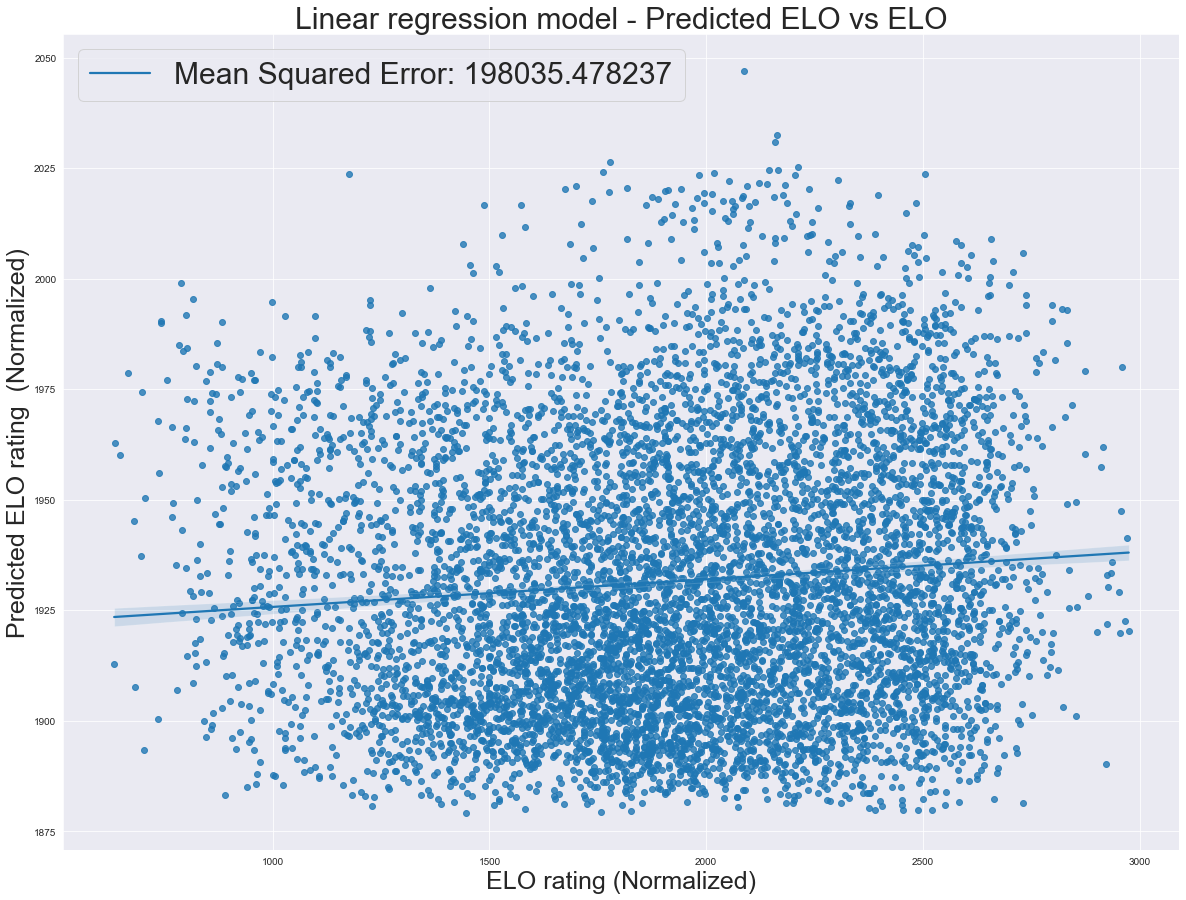

In [505]:
plt.figure(figsize = (20,15))
plt.title('Linear regression model - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = white_test_elo_transformed, y = y_pred, line_kws = {'label':f'Mean Squared Error: {mse_lin:4f}'})
plt.xlabel('ELO rating (Normalized)', fontsize = 25)
plt.ylabel('Predicted ELO rating  (Normalized)', fontsize = 25)
plt.legend(prop={'size': 30})
plt.savefig('images/NN_linreg_acc1.png')

(array([ 273., 1247., 2268., 4178., 6248., 7386., 6250., 6368., 3465.,
         349.]),
 array([-2.96057703, -2.42969867, -1.8988203 , -1.36794194, -0.83706357,
        -0.30618521,  0.22469316,  0.75557152,  1.28644989,  1.81732825,
         2.34820661]),
 <BarContainer object of 10 artists>)

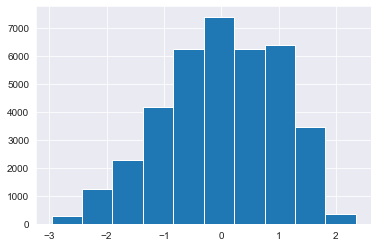

In [506]:
plt.hist(white_elo_transformed)

In [507]:
# zipping the elo together with the evaluations
# train_data_zip = list(zip(white_eval_train, black_eval_train, white_train))
# test_data_zip = list(zip(white_eval_test, black_eval_test, white_test))

train_data_zip = list(zip(white_eval_train, white_train))
test_data_zip = list(zip(white_eval_test, white_test))

In [508]:
black_elo = torch.stack(black_elo)
white_elo = torch.stack(white_elo)

# Creating the Neural Net

In [509]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, no_layers):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.no_layers = no_layers
        self.rnn = nn.RNN(input_size, hidden_size, no_layers, batch_first = True, bias = False)
        self.fc = nn.Linear(hidden_size,1, bias = False)
        self.final = nn.Tanh()

    def forward(self, x):

        out, _ = self.rnn(x)
        output ,lengths = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first = True)


        out = [output[e, i-1,:].unsqueeze(0)for e, i in enumerate(lengths)]
        out = torch.cat(out, dim = 0)


        out = self.fc(out)
        out = self.final(out)
        out = out[:,0]

        return out

In [510]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, no_layers):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.no_layers = no_layers
        torch.manual_seed(1)
        self.lstm = nn.LSTM(input_size, hidden_size, no_layers, batch_first = True, bias = True, dropout = 0.25)
        torch.manual_seed(2)
        self.fc = nn.Linear(hidden_size,1, bias = False)
        self.final = nn.Tanh()

    def forward(self, x):

        out, _ = self.lstm(x)
        output ,lengths = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first = True)


        out = [output[e, i-1,:].unsqueeze(0)for e, i in enumerate(lengths)]
        out = torch.cat(out, dim = 0)


        out = self.fc(out)
        out = self.final(out)
        out = out[:,0]

        return out

In [511]:
class MyCollator(object):
    '''
    Yields a batch from a list of Items
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''

    # remove that eventually. I'm going to need to make my dataset a tuple with evals and elo
    #def __init__(self):

    def __call__(self, batch):
        white_data = [item[0] for item in batch]
        #black_data = [item[1] for item in batch]
        target = [item[1] for item in batch]
        white_lens = [i.shape[0] for i in white_data]
        #black_lens = [i.shape[0] for i in black_data]


        white_data = torch.nn.utils.rnn.pad_sequence(white_data, batch_first=True,padding_value = 0)
        white_evals_packed = torch.nn.utils.rnn.pack_padded_sequence(white_data,batch_first = True, lengths=white_lens,enforce_sorted=False)

        # black_data = torch.nn.utils.rnn.pad_sequence(black_data, batch_first=True,padding_value = 0)
        # black_evals_packed = torch.nn.utils.rnn.pack_padded_sequence(black_data,batch_first = True, lengths=black_lens,enforce_sorted=False)


        target = torch.tensor(target,dtype=torch.float32)
        return [white_evals_packed, target]

In [512]:
input_size = 2
hidden_size = 32
no_layers = 4
batch_size = 128

In [513]:
# (defining my model)
model = MyRNN(input_size, hidden_size, no_layers)
model = MyLSTM(input_size, hidden_size, no_layers)
collate = MyCollator()

In [514]:
print(model.parameters)

<bound method Module.parameters of MyLSTM(
  (lstm): LSTM(2, 32, num_layers=4, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=32, out_features=1, bias=False)
  (final): Tanh()
)>


# Training the model

In [515]:
writer = SummaryWriter('runs/h45l4-2')

In [516]:
data_loader = torch.utils.data.DataLoader(train_data_zip, batch_size=batch_size, shuffle=True ,collate_fn=collate)

In [517]:
learning_rate = .1

In [518]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [519]:
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)

In [520]:
avg_losses = []
epochs = []
avg_loss = 0.1

for epoch in range(11):

    if (epoch+1) % 3 == 0:
        learning_rate /= 2
        optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)

    losses = []

    i = 0
    for white_evals, elo in data_loader:
        white_evals = white_evals.to(device)
        #black_evals = black_evals.to(device)
        elo = elo.to(device)
        outputs = model(white_evals)
        #print(outputs)
        #print(outputs.shape, elo.shape)
        loss = criterion(outputs,elo)
        # optimizing
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        i+=1

    change = stats.mean(losses)/avg_loss
    avg_loss = stats.mean(losses)

    # adding histograms to the summary writer
    for name, param in model.named_parameters():
        writer.add_histogram(name, np.array(param.detach().tolist()), epoch)

    # adding loss
    writer.add_scalar('Average loss',avg_loss, epoch)
    avg_losses.append(avg_loss)
    epochs.append(epoch)
    print(f'Epoch {epoch+1} step {i+1} - Learning Rate : {learning_rate}- Avg Loss: {avg_loss:3f} - Change in loss: {change}')


writer.close()

Epoch 1 step 239 - Learning Rate : 0.1- Avg Loss: 1.007474 - Change in loss: 10.074742889704824
Epoch 2 step 239 - Learning Rate : 0.1- Avg Loss: 0.958031 - Change in loss: 0.9509236289054619
Epoch 3 step 239 - Learning Rate : 0.05- Avg Loss: 0.947431 - Change in loss: 0.988935297224816
Epoch 4 step 239 - Learning Rate : 0.05- Avg Loss: 0.941607 - Change in loss: 0.993853421716902
Epoch 5 step 239 - Learning Rate : 0.05- Avg Loss: 0.937949 - Change in loss: 0.996114591495267
Epoch 6 step 239 - Learning Rate : 0.025- Avg Loss: 0.937481 - Change in loss: 0.9995015732545368
Epoch 7 step 239 - Learning Rate : 0.025- Avg Loss: 0.937058 - Change in loss: 0.9995481977944615
Epoch 8 step 239 - Learning Rate : 0.025- Avg Loss: 0.935777 - Change in loss: 0.9986336115097788
Epoch 9 step 239 - Learning Rate : 0.0125- Avg Loss: 0.934867 - Change in loss: 0.9990276083976436



KeyboardInterrupt



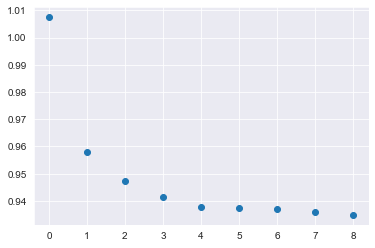

In [521]:
plt.scatter(epochs, avg_losses)

## Test data

In [522]:
model =model.eval()

In [523]:
model.to(device)

MyLSTM(
  (lstm): LSTM(2, 32, num_layers=4, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=32, out_features=1, bias=False)
  (final): Tanh()
)

In [524]:
test_data_loader = torch.utils.data.DataLoader(test_data_zip, batch_size=1, shuffle=False ,collate_fn=collate)

In [ ]:
losses = []
outputs = []
elos = []
for evals, elo in test_data_loader:
    #print("evals",evals.shape)
    evals = evals.to(device)
    elo = elo.to(device)
    output = model(evals)
    outputs.append(output.item())
    elos.append(elo.item())
    loss = criterion(output,elo)
    #print(f'Model prediction : {output} \n ELO : {elo} \n MSE : {loss}')
    losses.append(loss.item())
print(f'Average loss : {stats.mean(losses)}')

In [ ]:
plt.scatter(elos, outputs)

In [ ]:
elos = np.array(elos)
elos = np.reshape(elos, (len(elos),1))

outputs = np.array(outputs)
outputs = np.reshape(outputs, (len(outputs),1))

In [ ]:
print(elos[1], elos[2])
print(outputs[1], outputs[2])

In [ ]:
elos = welopt.inverse_transform(elos)
outputs = welopt.inverse_transform(outputs)

In [ ]:
print(elos[1], elos[2])
print(outputs[1], outputs[2])

In [ ]:
mse_model = mean_squared_error(elos,outputs)

In [ ]:
# de-normalize the elos - predicted and actual

In [ ]:
plt.figure(figsize = (20,15))
plt.title('Neural Network - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = elos, y = outputs, color ='green', line_kws = {'label':f'Mean Squared Error: {mse_model:4f}'})
plt.xlabel('ELO rating ', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})
plt.savefig('images/NN_model_acc1.png')

In [ ]:
sns.regplot(elos,outputs)

# Plotting the neural net architecture

In [ ]:
print(max(outputs))
print(min(outputs))

In [ ]:
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
#traced_script_module = torch.jit.trace(model, example)

In [ ]:
params =dict(model.named_parameters())

In [ ]:
dot = make_dot(output, params=params, show_attrs=False, show_saved=False)

In [ ]:
#dot.render("rnn_torchviz3", format="pdf", engine= 'neato') # doesn't seem to work great with padded & packed input...

# Use the predicted ELO to predict the winner of the game!